<a href="https://colab.research.google.com/github/akhavan12/discrete_covid_model/blob/master/Discrete_ver_8_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U ipykernel
!pip install swifter
import swifter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from ipywidgets import FloatSlider, IntSlider
pd.options.display.max_rows = 999
import matplotlib.cm as cm
import tqdm
#https://github.com/DataHerb/dataset-covid-19/tree/master/csse_covid_19_time_series

     |████████████████████████████████| 122kB 4.8MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.2.1 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')


In [0]:
def get_actual_ts(key='confirmed',country='Italy',rolling=4,population=60_000_000):
  """
    retrive informaton from actual cases database
    Parameters: 
    key (str): "confirmed", "recovered" or "dead"
    country (str): defult is italy (not case sensetive)
    rolling (int): rolling average for the daily cases
  
    Returns: 
    pandas dataframe: based on the type of the key
  
  """
 
  if key == "confirmed":
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
  elif key == "recovered":
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
  elif key == "dead":
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
  else:
    return -1


  df_=df[(df['Country/Region'].str.lower()==country.lower()) & (df['Province/State'].isnull())].T  
  df_ = df_.iloc[4:]
  df_ = df_.set_index(pd.to_datetime(df_.index))
  df_.columns=['cumulative']
  df_['daily'] = df_['cumulative'] - df_['cumulative'].shift(1).fillna(0)
  df_['rolling'] = df_['daily'].rolling(rolling).mean().fillna(0)
  df_['cumulative_percent']= (df_['cumulative'] / population) * 100
  df_['daily'] = (df_['daily']/ population) * 100
  df_['daily']=df_['daily'].rolling(10).sum()
  return df_


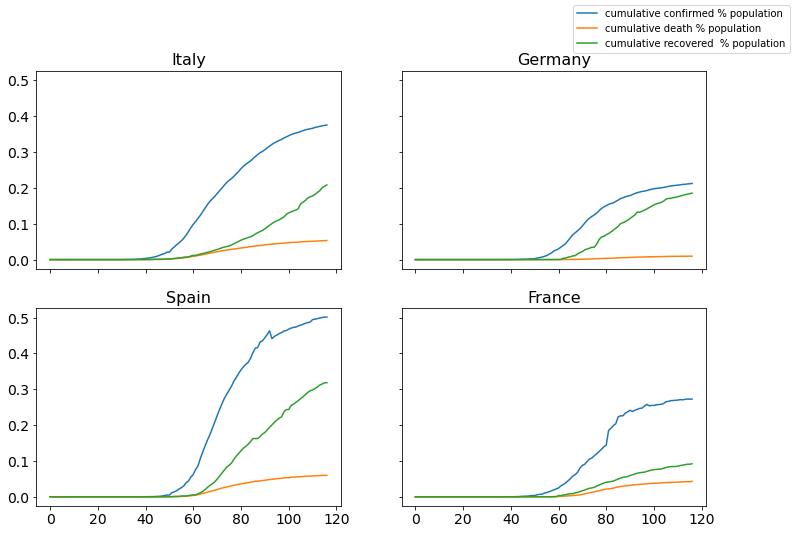

In [5]:
def country_situation(country = 'Italy',population = 60_000_000):
  df_confirmed=get_actual_ts(key='confirmed',country=country,population=population)
  df_death=get_actual_ts(key='dead',country=country,population=population)
  df_recovered=get_actual_ts(key='recovered',country=country,population=population)

  act_confirmed = df_confirmed['cumulative_percent'].values
  act_death = df_death['cumulative_percent'].values
  act_recovered =  df_recovered['cumulative_percent'].values
  act_daily_confirmed = df_recovered['daily'].values
  return [act_confirmed,act_death,act_recovered,act_daily_confirmed]

italy_data = country_situation(country = 'Italy',population = 60_000_000)
germany_data = country_situation(country = 'Germany',population = 83_000_000)
spain_data = country_situation(country = 'Spain',population = 46_000_000)
france_data = country_situation(country = 'France',population = 65_000_000)



f,axa = plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=True)
ax=axa.ravel()
ax[0].plot(italy_data[0],label='cumulative confirmed % population')
ax[0].plot(italy_data[1],label='cumulative death % population')
ax[0].plot(italy_data[2],label='cumulative recovered  % population')
ax[0].set_title('Italy',fontsize=16)
ax[0].tick_params(labelsize=14)


ax[1].plot(germany_data[0],label=None)
ax[1].plot(germany_data[1],label=None)
ax[1].plot(germany_data[2],label=None)
ax[1].set_title('Germany',fontsize=16)
ax[1].tick_params(labelsize=14)


ax[2].plot(spain_data[0],label=None)
ax[2].plot(spain_data[1],label=None)
ax[2].plot(spain_data[2],label=None)
ax[2].set_title('Spain',fontsize=16)
ax[2].tick_params(labelsize=14)


ax[3].plot(france_data[0],label=None)
ax[3].plot(france_data[1],label=None)
ax[3].plot(france_data[2],label=None)
ax[3].set_title('France',fontsize=16)

ax[3].tick_params(labelsize=14)


f.legend()

In [7]:
prc = 2 ## Precision for the calculations
T = []

confirmed_ = []


def set_probs_Other_Exposed(Probs):
  ### Other_Exp,Other_Symp
  Probs["Other_Exposed"] = [
          [1.00,0.00], #0
          [0.80,0.20], #1
          [0.60,0.40], #2
          [0.30,0.70], #3
          [0.00,1.00], #4
  ]
def set_probs_Other_Symp(Probs):
  ### Other_Symp,Susceptible   
  Probs['Other_Symp'] =[[0.80,  0.20],
                        [0.50,  0.50 ], 
                        [0.00,  1.00]]      

def set_probs_M(Probs,num_days = 14, alpha_r=.8, v50=5):
  ### M,R,Severe
  def m_at_day(num_days = 14, alpha_r = .8, v50=5):
      ## https://www.graphpad.com/guides/prism/7/curve-fitting/reg_classic_boltzmann.htm
      Tdays = np.arange(num_days) #x
      Top = 1
      Buttom = 0
      slope= 1.8
      m_to_m = Top +  (Buttom - Top)/(1+ np.exp((v50 - Tdays)/slope))
      m_to_r = alpha_r*(1 - m_to_m)
      m_to_v = 1 - (m_to_m+m_to_r)
      return pd.DataFrame({'m_to_m': m_to_m, 'm_to_r' :m_to_r,'m_to_v': m_to_v})
  
  Probs["M"] = m_at_day(num_days = num_days , alpha_r = alpha_r, v50=v50).values

def set_probs_MU(Probs):
  ### MU,R
  Probs["M_undiagnosed"] = [
          [1.00,0.00], #0
          [0.80,0.20], #1
          [0.60,0.40], #2
          [0.50,0.50], #3
          [0.40,0.60], #4
          [0.30,0.70], #5
          [0.30,0.70], #6
          [0.30,0.70], #7
          [0.30,0.70], #8
          [0.30,0.70], #9
          [0.30,0.70], #10 
          [0.30,0.70], #11
          [0.30,0.70], #12 
          [0.00,1.00]  #13
  ]

def set_probs_Severe(Probs,num_days=14,alpha_r = .4,alpha_v = .2, v50= 7):
  ### Severe,R,V,D

  def w_at_day(num_days = 14,alpha_r = .4,alpha_v = .2):
      ## https://www.graphpad.com/guides/prism/7/curve-fitting/reg_classic_boltzmann.htm
      Tdays = np.arange(num_days) #x
      Top = 1
      Buttom = 0
      v50= num_days/3
      slope= 1.8
      w_to_w = Top +  (Buttom - Top)/(1+ np.exp((v50 - Tdays)/slope))

      w_to_r = alpha_r*(1 - w_to_w)
      w_to_v = alpha_v*(1 - w_to_w)
      w_to_d = 1 - (w_to_w+w_to_r+w_to_v)
      return pd.DataFrame({'w_to_w': w_to_w, 
                           'w_to_r' :w_to_r, 
                           'w_to_v' :w_to_v,
                           'w_to_d': w_to_d})
  Probs["Severe"] = w_at_day(num_days = num_days,alpha_r = alpha_r,alpha_v = alpha_v).values

def set_probs_ventilator(Probs, num_days=20, v_to_r_ratio=.4, v50=10):
  ### V,R,D 
  def v_at_day(num_days = 20,alpha_r = .4, v50=10):
      ## https://www.graphpad.com/guides/prism/7/curve-fitting/reg_classic_boltzmann.htm
      Tdays = np.arange(num_days) #x
      Top = 1
      Buttom = 0
      slope= 1.8
      v_to_v = Top +  (Buttom - Top)/(1+ np.exp((v50 - Tdays)/slope))
      v_to_r = alpha_r*(1 - v_to_v)
      v_to_d = 1 - (v_to_v+v_to_r)
      return pd.DataFrame({'v_to_v': v_to_v, 'v_to_r' :v_to_r,'v_to_d': v_to_d})
  Probs["ventilator"] = v_at_day(num_days = num_days ,alpha_r =v_to_r_ratio,v50=v50).values

def set_probs_Symp(Probs):
  ### Symp,M   0: not tested, 1: tested positive ,2: tested negative
  Probs['Symp'] =[[0.20,  0.80 , 0.00 ], #0 Testing and + cases go to Mild cases , negative cases go back to Healthy
                  [0.00,  0.60 , 0.40 ]]      #1 ###  all remainings go to Mild cases 

def set_probs_E(Probs):
  ### E,Symp
  Probs["E"] = [[1.00,0.00], #0 ### first day of exposure
                [0.50,0.50], #1       
                [0.40,0.60], #2 
                [0.30,0.70], #4
                [0.20,0.80], #5
                [0.20,0.80], #6
                [0.20,0.80], #7
                [0.20,0.80], #8
                [0.20,0.80], #9
                [0.20,0.80], #10
                [0.05,0.95], #11
                [0.05,0.95], #12
                [0.05,0.95], #13
                [0.05,0.95], #14
                [0.05,0.95], #15
                [0.05,0.95], #16
                [0.05,0.95], #17
                [0.05,0.95], #18
                [0.05,0.95], #19
                [0.00,1.00]  #20
                ]

"""  def e_at_day(num_days = 20):
      ## https://www.graphpad.com/guides/prism/7/curve-fitting/reg_classic_boltzmann.htm
      Tdays = np.arange(num_days) #x
      Top = 1
      Buttom = 0
      v50= 7
      slope= 1.8
      e_to_m = Top +  (Buttom - Top)/(1+ np.exp((v50 - Tdays)/slope))
      e_to_e = 1 - (e_to_m)
      return pd.DataFrame({'e_to_e': e_to_e, 'e_to_m' :e_to_m})
  Probs["E"] = e_at_day(20).values"""


'  def e_at_day(num_days = 20):\n      ## https://www.graphpad.com/guides/prism/7/curve-fitting/reg_classic_boltzmann.htm\n      Tdays = np.arange(num_days) #x\n      Top = 1\n      Buttom = 0\n      v50= 7\n      slope= 1.8\n      e_to_m = Top +  (Buttom - Top)/(1+ np.exp((v50 - Tdays)/slope))\n      e_to_e = 1 - (e_to_m)\n      return pd.DataFrame({\'e_to_e\': e_to_e, \'e_to_m\' :e_to_m})\n  Probs["E"] = e_at_day(20).values'

In [0]:

P={}
EXP_Other =[]
MU = []     ## Mild undiagnosed
E = []       ## Exposed 
H = []      ## Healthy (susceptible)
Symp = []   ## Symptomatic
M = []      ## Mild Symptomatic
W = []      ## Severe
V = []       ## Ventilator
R = []      ## Recovered
D = []      ## Dead
add_M = []  
add_sym = [] 
add_E = [] 
add_Severe = []
add_ventilator = []

Track_M = []
Track_E = []
Track_V = []
Track_W = []

         
         
               
       


def calculate(B = 0.1,
              v_to_r_ratio = 0.3,
              w_to_r_ratio = 0.3,
              m_to_r = 0.8,
              m_v50=7,
              w_v50=7,
              v_v50=7):
  
  initial_population = 1000
  initial_exposed = 1
  lenght_t = 117
  m_days=15
  w_days=15
  v_days=15

  global P
  global EXP_Other
  global confirmed_
  global MU     ## Mild undiagnosed
  global E      ## Exposed 
  global H      ## Healthy (susceptible)
  global Symp   ## Symptomatic
  global M      ## Mild Symptomatic
  global W      ## Severe
  global V      ## Ventilator
  global R      ## Recovered
  global D      ## Dead
  global add_M  
  global add_sym 
  global add_E 
  global add_Severe
  global add_ventilator
  global Track_M
  global Track_E
  global Track_V
  global Track_W
  lenght_t  = int(lenght_t)
  Beta = np.repeat(B,lenght_t)

  Track_M = []
  Track_E = []
  Track_V = []
  Track_W = []

  P={}
  set_probs_Severe(P,num_days=w_days,alpha_r=.4,alpha_v=.2,v50=w_v50)
  set_probs_ventilator(P,num_days=v_days,v_to_r_ratio=v_to_r_ratio,v50=v_v50)
  set_probs_M(P,num_days=m_days,alpha_r=m_to_r,v50=m_v50)
  ## a bit more fixed than the rest of the variables

  set_probs_Symp(P)
  set_probs_E(P)
  


  #### Other deiseases variables: NOT COVID
  set_probs_Other_Exposed(P)
  set_probs_Other_Symp(P)
  #EXP_Other = np.zeros((len(P['Other_Exposed']),lenght_t))
  
  #### COVID variables
  set_probs_MU(P) ### undiagnosed MILD COVID
  MU = np.zeros((14,lenght_t))
  
  E = np.zeros((len(P['E']),lenght_t))
  Symp = np.zeros((len(P['Symp']),lenght_t))
  M = np.zeros((len(P['M']),lenght_t))
  W = np.zeros((len(P['Severe']),lenght_t))
  V = np.zeros((len(P['ventilator']),lenght_t))
  R = np.zeros(lenght_t)
  D = np.zeros(lenght_t)
  H = np.zeros(lenght_t)
  confirmed_ = np.zeros(lenght_t)


  add_M = []
  add_sym = []
  add_E = []
  add_Severe = []
  add_ventilator = []
############################################################
############################################################
############################################################
  #print(E.shape)
  E[0,0] = initial_exposed
  M[0,0] = 0
############################################################
############################################################
############################################################
  H[0] = 1000#initial_population# - E[0,0]



  for t in range(lenght_t-1):
    R[t+1] = R[t]
    D[t+1] = D[t]

    for state in range(len(P['E'])):
      try:
        E[state+1,t+1] =  np.round(E[state,t] * P["E"][state][0],prc) ## Stay exposed conditions
      except:
        pass
      Symp[0,t+1] = np.round(Symp[0,t+1] + E[state,t] * P["E"][state][1],prc)  ## at time t+1 add the portion of the Exposed to the symptomatic
    
    
    ### Symptomatic states Tests take place here
    #################################################                            0      1 
    Symp[1,t+1] = np.round(Symp[0,t] * P["Symp"][0][0],prc)         ### P["Symp"][0][0] ==> [[0,1]  [0,1]]
                                                      ###                      |   |   |  |   
                                                      ###         next day    Symp M
                                                      ###         next day             Symp M
    ### from Symptomatic to mild --> where testing also happens
    M[1,t+1] = np.round(Symp[0,t] * P["Symp"][0][1],prc)                 ### From state 0 to Mild state 0
    M[1,t+1] = np.round(M[1,t+1] +  Symp[1,t] * P["Symp"][1][1],prc)     ### From state 1 to Mild state 0

    Track_M.append(M[:,t])

    MU[0,t+1] = np.round(Symp[0,t] * P["Symp"][0][2],prc)                 ### From state 0 to Mild state 0
    MU[0,t+1] = np.round(MU[0,t+1] +  Symp[1,t] * P["Symp"][1][2],prc)     ### From state 1 to Mild state 0


    #################################################
    #add_sym.append(Symp[0,t] - (Symp[0,t] * P["Symp"][0][0]+Symp[0,t] * P["Symp"][0][1]))
    #add_sym.append(Symp[1,t] -  Symp[1,t] * P["Symp"][1][1] )

    ### Mild cases are calculated in this section
    for state in range(1,len(P['M'])):
      ### M,R,Severe
      try:
        M[state+1,t+1] =  np.round(M[state,t] * P["M"][state][0],prc) ## from state= state --> to state+1
      except:
        pass
      R[t+1] = np.round(R[t+1] + M[state,t] * P["M"][state][1],prc) ## from Mild to recovered
      W[0,t+1] = W[0,t+1] + np.round(M[state,t] * P["M"][state][2],prc)


    ###############################################
    ### Un-diagnosed Mild 
    for state in range(0,len(P['M_undiagnosed'])):
      ### M,R,Severe
      try:
        MU[state+1,t+1] =  np.round(MU[state,t] * P["M_undiagnosed"][state][0],prc) ## from state= state --> to state+1
      except:
        pass

      R[t+1] = np.round(R[t+1] + MU[state,t] * P["M_undiagnosed"][state][1],prc) ## from undiagnosed_Mild to recovered
      #if MU[state,t] * P["M_undiagnosed"][state][1]>0:
        #print(state, t,':', MU[state,t] * P["M_undiagnosed"][state][1])

    ##########################################
    ### Severe Cases 

    for state in range(0,len(P['Severe'])):
    ### Severe,R,V,D
      try:
        W[state+1,t+1] =  np.round(W[state,t] * P["Severe"][state][0],prc)
      except:
        pass
      R[t+1] = np.round(R[t+1] + W[state,t] * P["Severe"][state][1],prc)

      if W[state,t] * P["Severe"][state][2]>0:
        V[0,t+1] = V[0,t+1] + np.round(W[state,t] * P["Severe"][state][2],prc)

      D[t+1] = D[t+1] + np.round(W[state,t] * P["Severe"][state][3],prc)


    ###########################################
    ### ventilator cases

    for state in range(0,len(P['ventilator'])):
    ### V,R,D 
      try: 
        V[state+1,t+1] = np.round( V[state,t] * P["ventilator"][state][0],prc)
      except:
        pass
      R[t+1] = R[t+1] + np.round(V[state,t] * P["ventilator"][state][1],prc)
      D[t+1] = D[t+1] + np.round(V[state,t] * P["ventilator"][state][2],prc)



    if H[t] > ((H[t]/initial_population) * M[:,t].sum() * Beta[t]):
      E[0,t+1] = (H[t]/initial_population)  *  M[:,t].sum() * Beta[t]
      H[t+1]= H[t] - np.round(E[0,t+1])
      confirmed_[t+1]=confirmed_[t] + (H[t]/initial_population)  *  M[:,t].sum() * Beta[t]

    elif ((H[t]>0) & ((H[t]/initial_population)  *  M[:,t].sum() * Beta[t])):
      E[0,t+1] = H[t]
      H[t+1]= 0

    Track_E.append(E[:,t])
    Track_V.append(V[:,t])
    Track_W.append(W[:,t])

  return (D/1000,R/1000)

In [14]:



actual_d = list(italy_data[1][:])
actual_r = list(italy_data[2][:])


results = []
for B in tqdm.tqdm_notebook(np.arange(.28,0.38,.03)):
  for m_v50 in range(6,8):
    for w_v50 in range(2,4):
      for v_v50 in range(2,4):
        for m_to_r in np.arange(.1,0.3,.1):
          for v_to_r_ratio in np.arange(.05,.4,.1):
            for w_to_r_ratio in np.arange(.05,.4,.1):
              for m_to_r in np.arange(.6,.8,.1):
                sim_d,sim_r = calculate(B = B,
                  v_to_r_ratio = v_to_r_ratio,
                  w_to_r_ratio = w_to_r_ratio,
                  m_to_r = m_to_r,
                  m_v50=m_v50,
                  w_v50=w_v50,
                  v_v50=v_v50)

                results.append({
                 'Beta' : B,
                 'v_to_r_ratio' : v_to_r_ratio,
                 'w_to_r_ratio': w_to_r_ratio,
                 'm_to_r' : m_to_r,
                 'm_v50': m_v50,
                 'w_v50': w_v50,
                 'v_v50': v_v50,
                 'd_sqr_error' : np.sum((actual_d-sim_d)**2),
                 'r_sqr_error' : np.sum((actual_r-sim_r)**2)
                 }
                 )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [15]:


df_results=pd.DataFrame(results)
df_results.head()

,Beta,v_to_r_ratio,w_to_r_ratio,m_to_r,m_v50,w_v50,v_v50,d_sqr_error,r_sqr_error
0,0.28,0.05,0.05,0.6,6,2,2,0.058613,0.345262
1,0.28,0.05,0.05,0.7,6,2,2,0.066686,0.322659
2,0.28,0.05,0.05,0.8,6,2,2,0.075983,0.306011
3,0.28,0.05,0.15,0.6,6,2,2,0.058613,0.345262
4,0.28,0.05,0.15,0.7,6,2,2,0.066686,0.322659


In [0]:
df_results.to_csv('Optimization_v2.csv')

In [21]:
df_results.sort_values(by=['d_sqr_error','r_sqr_error'])

,Beta,v_to_r_ratio,w_to_r_ratio,m_to_r,m_v50,w_v50,v_v50,d_sqr_error,r_sqr_error,multip
1934,0.34,0.15,0.05,0.8,7,2,2,0.004521,3.857493,0.017438
1937,0.34,0.15,0.15,0.8,7,2,2,0.004521,3.857493,0.017438
1940,0.34,0.15,0.25,0.8,7,2,2,0.004521,3.857493,0.017438
1943,0.34,0.15,0.35,0.8,7,2,2,0.004521,3.857493,0.017438
1982,0.34,0.15,0.05,0.8,7,2,2,0.004521,3.857493,0.017438
...,...,...,...,...,...,...,...,...,...,...
2889,0.37,0.05,0.35,0.6,7,3,2,0.250949,5.450148,1.367709
2928,0.37,0.05,0.05,0.6,7,3,2,0.250949,5.450148,1.367709
2931,0.37,0.05,0.15,0.6,7,3,2,0.250949,5.450148,1.367709
2934,0.37,0.05,0.25,0.6,7,3,2,0.250949,5.450148,1.367709


In [0]:
df_results['multip']=df_results['d_sqr_error']*df_results['r_sqr_error']

In [20]:
df_results.sort_values(by='multip')

,Beta,v_to_r_ratio,w_to_r_ratio,m_to_r,m_v50,w_v50,v_v50,d_sqr_error,r_sqr_error,multip
411,0.28,0.25,0.15,0.6,7,2,2,0.019288,0.005451,0.000105
456,0.28,0.25,0.05,0.6,7,2,2,0.019288,0.005451,0.000105
459,0.28,0.25,0.15,0.6,7,2,2,0.019288,0.005451,0.000105
609,0.28,0.25,0.35,0.6,7,3,2,0.019288,0.005451,0.000105
462,0.28,0.25,0.25,0.6,7,2,2,0.019288,0.005451,0.000105
...,...,...,...,...,...,...,...,...,...,...
2934,0.37,0.05,0.25,0.6,7,3,2,0.250949,5.450148,1.367709
2742,0.37,0.05,0.25,0.6,7,2,2,0.250949,5.450148,1.367709
2694,0.37,0.05,0.25,0.6,7,2,2,0.250949,5.450148,1.367709
2880,0.37,0.05,0.05,0.6,7,3,2,0.250949,5.450148,1.367709
